In [7]:
import torch
from torch import Tensor
from torch.nn import functional as F
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [8]:
def y_distribution(beta: Tensor, K: int, kron_x: Tensor) -> Tensor:
    """
    Args:
        beta: Tensor of accuracy values for each batch of shape (batch_size,).
        K: Number of classes (usually vocabulary size etc.)
        kron_x: One-hot encoded input tensor of shape (batch_size, seq_len, K).
    Returns:
        Noisy version of kron_x with the amount of noise controlled
        by beta. The shape of the output tensor is the same as kron_x, i.e., (batch_size, seq_len, K).
    """
    beta = beta.view(
        -1, 1, 1
    )  # allows for broadcasting with reach appropriate batch in kron_x
    mean = beta * (K * kron_x - 1)
    variance = beta * K
    epsilon = torch.normal(0, 1, kron_x.shape, device=kron_x.device)
    return mean + (variance**0.5) * epsilon


In [9]:
def divergence_sampling(batch_size, beta_1, K):
    beta = torch.ones((batch_size,)) * beta_1
    kron_x = torch.eye(K // 2, K).repeat(batch_size, 1, 1)
    y = y_distribution(beta, K, kron_x)
    y = torch.log_softmax(y, dim=-1)
    return F.kl_div(y, kron_x, reduction="batchmean", log_target=False)

In [10]:
batch_size = 32 * 100
K = 38
sample_points = []
averages = []
repeats = 10

In [11]:
for i in tqdm(torch.arange(0.535, 0.54, 0.0001)):
    sample_points.append(i.item())
    current_values = []
    for _ in range(repeats):
        current_values.append(divergence_sampling(batch_size, i, K).item())
    averages.append(sum(current_values) / len(current_values))

  0%|          | 0/51 [00:00<?, ?it/s]

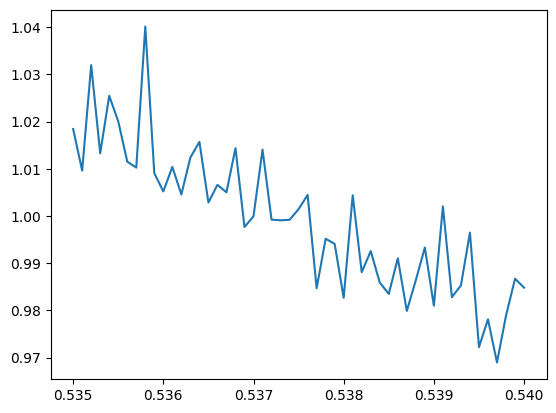

In [12]:
plt.plot(sample_points, averages)